# Ejercicio Covid-19

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
#Fechas de hoy(datos España) y ayer (datos inetrnacionales)
from datetime import datetime, timedelta
from datetime import date
date_today = date.today()
date_today_complete = date.today()
date_daybefore = date_today - timedelta(days=1)
date_today = date_today.strftime('%d/%m')
date_daybefore = date_daybefore.strftime('%d/%m')

In [6]:
path_spain = 'pdf_files/Actualizacion_67_COVID-19.pdf'
new_inform = 67

# Preparación inicial

## Descargar PDFs del Ministerio de Sanidad

In [7]:
#Importar PDFs
import os
import requests
from bs4 import BeautifulSoup
import re

#Función para descargar PDFs
def download_file(url):
    local_filename = url.split('/')[-1]
    # NOTE the stream=True parameter below
    with requests.get(url, stream=True) as r:
        r.raise_for_status()
        with open(local_filename, 'wb') as f:
            for chunk in r.iter_content(chunk_size=8192): 
                if chunk: # filter out keep-alive new chunks
                    f.write(chunk)
                    # f.flush()
    print(local_filename)
    return local_filename

#
DAILY_FOLDER = "./pdf_files/"
ES_REPORT_URL = "https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/situacionActual.htm"
PDF_BASE_URL = "https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/"

#Función para revisar los nombres de archivos
def get_file_names(url):
    try:
        req_page = requests.get(url, verify=True)
    except Exception as e:
        raise Exception(f"Could not get web page content: {e}")
    
    re_pdf = re.compile(r"(documentos/.+?\.pdf)")

    pdf_paths = list(set(re_pdf.findall(req_page.text)))
    return pdf_paths

#Reviso los nomnbres de archivos
pdf_paths = get_file_names(ES_REPORT_URL)

pdf_paths = [PDF_BASE_URL+i for i in pdf_paths if "Informacion_inicial_alerta" not in i]


for pdf_path in pdf_paths:
        pdf_name = pdf_path.split("/")[-1]
        pdf_path_get = requests.get(pdf_path)
        with open(
            os.path.join(DAILY_FOLDER, pdf_name),
            'wb'
        ) as f:
            f.write(pdf_path_get.content)
            
# Descargo PDFs a raíz
for i in range(60,new_inform):
    path = 'https://www.mscbs.gob.es/profesionales/saludPublica/ccayes/alertasActual/nCov-China/documentos/Actualizacion_{}_COVID-19.pdf'.format(i+1)
    download_file(path)

# Muevo los archivos a otra carpeta
lst_files = [file for file in os.listdir() if 'Act' in file]
if os.path.isdir("./pdf_files/"):
    for f in lst_files:
        os.rename("./{}".format(f), "./pdf_files/{}".format(f))
else:
    os.mkdir("./pdf_data/")
    for f in lst_files:
        os.rename("./{}".format(f), "./pdf_files/{}".format(f))

Actualizacion_61_COVID-19.pdf
Actualizacion_62_COVID-19.pdf
Actualizacion_63_COVID-19.pdf
Actualizacion_64_COVID-19.pdf
Actualizacion_65_COVID-19.pdf
Actualizacion_66_COVID-19.pdf
Actualizacion_67_COVID-19.pdf


## Parsear PDF descargado

In [8]:
# Parsear PDF

from tika import parser
import pandas as pd
from io import StringIO
import re
import tabula

raw = parser.from_file(path_spain)

#Cojo partes del PDF
ind_ini = raw['content'].find('en España:')
ind_fin = raw['content'].find('mundo:')


#Coger fecha del PDF
def get_fecha(string):
    ind_ini = string.find('(COVID-19)')
    ind_fin = string.find('.20')
    print(string[ind_ini:ind_fin])
    return string[ind_ini:ind_fin].split('\n')[-1]+'.2020'

fecha_data_spain = get_fecha(raw['content'])
print(fecha_data_spain)

# Coger tablar primera página
import tabula
from tabula import read_pdf
data_spain_ccaa = tabula.read_pdf(path_spain, stream=True, pages=1)[0]
data_spain_ccaa.columns = ['Comunidades Autónomas','Confirmados', 'IA', 'Hospitalizados', 'UCI', 'Fallecidos', 'Curados', 'Nuevos casos (24h)']
data_spain_ccaa.rename(index={23: "Casos totales en España" + " (act." + date_today + ")" }, inplace=True)
data_spain_ccaa = data_spain_ccaa.iloc[4:23]
data_spain_ccaa = data_spain_ccaa[['Comunidades Autónomas', 'Confirmados', 'Curados', 'Fallecidos', 'Nuevos casos (24h)']]

#Quitar símbolos raros qye nos sobran
data_spain_ccaa['Confirmados'] = data_spain_ccaa['Confirmados'].str.replace('.','')
data_spain_ccaa['Fallecidos'] = data_spain_ccaa['Fallecidos'].str.replace('.','')
data_spain_ccaa['Curados'] = data_spain_ccaa['Curados'].str.replace('.','')
data_spain_ccaa['Nuevos casos (24h)'] = data_spain_ccaa['Nuevos casos (24h)'].str.replace('.','')

# Seleccionar índice Comunidades Autónomas
data_spain_ccaa = data_spain_ccaa.set_index('Comunidades Autónomas')
data_spain_ccaa

(COVID-19).  

06.04
06.04.2020


,Confirmados,Curados,Fallecidos,Nuevos casos (24h)
Comunidades Autónomas,,,,
Andalucía,8581,798,491,280
Aragón,3347,565,284,115
Asturias,1646,222,86,41
Baleares,1320,531,81,27
Canarias,1649,157,85,27
Cantabria,1483,118,77,42
Castilla La Mancha,10602,1259,1132,571
Castilla y León,9116,2533,919,367
Cataluña,26824,10088,2760,792


# Resumen de datos INICIAL

## Resumen datos globales CSV: covid19_data_drive_resume.csv

In [91]:
##### EN EL MUNDO

## Datos totales mundiales
data_confirmed_world = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" )
data_deaths_world = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
data_recovered_world = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv" )

#Saco un dataset con solo los países
data_confirmed_world = data_confirmed_world.groupby("Country/Region", as_index=False).sum()
data_deaths_world = data_deaths_world.groupby("Country/Region", as_index=False).sum()
data_recovered_world = data_recovered_world.groupby("Country/Region", as_index=False).sum()

# Hago transposición de los datos para mover las columnas en filas 
data_confirmed_world = data_confirmed_world.set_index('Country/Region').transpose()
data_deaths_world = data_deaths_world.set_index('Country/Region').transpose()
data_recovered_world = data_recovered_world.set_index('Country/Region').transpose()

#Selecciono los últimos datos
data_confirmed_world_actual = int(data_confirmed_world.sum(axis=1).iloc[-1])
data_deaths_world_actual = int(data_deaths_world.sum(axis=1).tail(1).iloc[-1])
data_recovered_world_actual = int(data_recovered_world.sum(axis=1).tail(1).iloc[-1])

#Selecciono los datos del día anterior
data_confirmed_world_daybefore = int(data_confirmed_world.sum(axis=1).iloc[-2])
data_deaths_world_daybefore = int(data_deaths_world.sum(axis=1).tail(2).iloc[-2])
data_recovered_world_daybefore = int(data_recovered_world.sum(axis=1).tail(2).iloc[-2])

#Nuevos casos 24h
data_confirmed_world_newcases = data_confirmed_world_actual - data_confirmed_world_daybefore
data_deaths_world_newcases = data_deaths_world_actual - data_deaths_world_daybefore
data_recovered_world_newcases = data_recovered_world_actual -data_recovered_world_daybefore
newcases_list = [data_confirmed_world_newcases, data_recovered_world_newcases, data_deaths_world_newcases]
#FALTA AÑADIR LA NUEVA FILA

#Modificar para últimos datos
data_world_resume = pd.DataFrame({'Confirmados':[data_confirmed_world_actual], 'Curados':[data_recovered_world_actual],'Fallecidos':[data_deaths_world_actual]})
data_columns = ['Confirmados', 'Curados','Fallecidos']
data_world_resume.columns = data_columns
data_world_resume.rename(index={0: "Casos en el mundo"}, inplace=True)

##### EN ESPAÑA 

#Importado de PDF
import tabula
from tabula import read_pdf
data_spain_resume = tabula.read_pdf(path_spain, stream=True, pages=1)[0]
data_spain_resume.columns = ['Comunidades Autónomas','Confirmados', 'IA', 'Hospitalizados', 'UCI', 'Fallecidos', 'Curados', 'Nuevos casos (24h)']
data_spain_resume.rename(index={23: "Casos en España"}, inplace=True)

#Selecciono los datos del día anterior
data_spain_resume_newcases = data_spain_resume['Nuevos casos (24h)'].tail(1)
#FALTA AÑADIR LA NUEVA FILA

#Selecciono los últimos casos
data_spain_resume = data_spain_resume.tail(1)
data_spain_resume = data_spain_resume[['Confirmados', 'Curados', 'Fallecidos']]
data_spain_resume['Confirmados'] = data_spain_resume['Confirmados'].str.replace('.','')
data_spain_resume['Fallecidos'] = data_spain_resume['Fallecidos'].str.replace('.','')
data_spain_resume['Curados'] = data_spain_resume['Curados'].str.replace('.','')



##### JUNTAR
data_resume_final = pd.concat([data_world_resume, data_spain_resume])

data_resume_final.to_csv('covid19_data_drive_resume.csv', sep = ';')
data_resume_final.head()
#df.merge(pd.DataFrame(data = [s.values] * len(s), columns = s.index), left_index=True, right_index=True)
data_resume_final



,Confirmados,Curados,Fallecidos
Casos en el mundo,1272115,260012,69374
Casos en España,135032,40437,13055


In [92]:
data_spain_resume_newcases

Casos en España    4.273
Name: Nuevos casos (24h), dtype: object

# Gráficos a nivel mundial

## Preparación general de datos por países

In [10]:
# Datos https://github.com/CSSEGISandData/COVID-19.git
data = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" )
data.sample(3)

#Saco un dataset con solo los países
data_countries = data.groupby("Country/Region", as_index=False).sum()
#Se ve que están todos y comprobado que suma
data_countries[::]

# Hago transposición de los datos para mover las columnas en filas 
data_trans = data_countries.set_index('Country/Region').transpose()
# Y me quedo sólo con los datos temporales y número de casos
data_time = data_trans[2:]

# Cogemos solo determinados países
data_time = data_time[['China', 'France', 'Germany', 'Iran','Italy', 'Korea, South', 'Norway','Spain', 'US', 'United Kingdom']]

#Hago listado de Countries
list_countries = data_time.columns
list_countries

# Para coger los países que en día 20 tienen más de 1000 casos: data_countries = data_countries[data_countries["3/17/20"] >= 1000 ]
data_time.tail(2)

#Convierto la columna fecha en datetime
from datetime import date
data_time.index = pd.to_datetime(data_time.index)
data_time.tail()



Country/Region,China,France,Germany,Iran,Italy,"Korea, South",Norway,Spain,US,United Kingdom
2020-04-01,82361.0,57749.0,77872.0,47593.0,110574.0,9887.0,4863.0,104118.0,213372.0,29865.0
2020-04-02,82432.0,59929.0,84794.0,50468.0,115242.0,9976.0,5147.0,112065.0,243453.0,34173.0
2020-04-03,82511.0,65202.0,91159.0,53183.0,119827.0,10062.0,5370.0,119199.0,275586.0,38689.0
2020-04-04,82543.0,90848.0,96092.0,55743.0,124632.0,10156.0,5550.0,126168.0,308850.0,42477.0
2020-04-05,82602.0,93773.0,100123.0,58226.0,128948.0,10237.0,5687.0,131646.0,337072.0,48436.0


## MUNDO: CSV : covid19_data_drive_actual.csv

In [11]:
######### Confirmados

data_confirmed = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv" )
#Saco un dataset con solo los países
data_confirmed = data_confirmed.groupby("Country/Region", as_index=False).sum()
# Hago transposición de los datos para mover las columnas en filas 
data_confirmed = data_confirmed.set_index('Country/Region').transpose()
# Y me quedo sólo con los datos temporales y número de casos
data_confirmed = data_confirmed[2:]
# Cogemos solo determinados países
data_confirmed = data_confirmed[['China', 'France', 'Germany', 'Italy','Spain', 'US', 'United Kingdom']]
data_confirmed = data_confirmed[-1:]
print(data_confirmed)

######### Muertos

data_deaths = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
#Saco un dataset con solo los países
data_deaths = data_deaths.groupby("Country/Region", as_index=False).sum()
#Se ve que están todos y comprobado que suma
data_deaths[::]
# Hago transposición de los datos para mover las columnas en filas 
data_deaths = data_deaths.set_index('Country/Region').transpose()

# Y me quedo sólo con los datos temporales y número de casos
data_deaths = data_deaths[2:]
data_deaths.tail()
# Cogemos solo determinados países
data_deaths = data_deaths[['China', 'France', 'Germany', 'Italy','Spain', 'US', 'United Kingdom']]
data_deaths = data_deaths[-1:]
print(data_deaths)

######### Recuperados

data_recovered = pd.read_csv("COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv" )
#Saco un dataset con solo los países
data_recovered = data_recovered.groupby("Country/Region", as_index=False).sum()
# Hago transposición de los datos para mover las columnas en filas 
data_recovered = data_recovered.set_index('Country/Region').transpose()
# Y me quedo sólo con los datos temporales y número de casos
data_recovered = data_recovered[2:]
# Cogemos solo determinados países
data_recovered = data_recovered[['China', 'France', 'Germany', 'Italy','Spain', 'US', 'United Kingdom']]
data_recovered = data_recovered[-1:]
print(data_recovered)

######### Merge de datos

# Saco la fecha:
from datetime import datetime, timedelta
date_today_intern = date.today()
date_today_intern = date_today_intern.today() - timedelta(days=1) #Quito uno porque esta base de datos siempre muestra datos del día anterior
date_today_intern = date_today_intern.strftime('%d/%m')
print(date_today_intern)

#Juntar ahora datos
data_columns = ['Confirmados', 'Curados', 'Fallecidos']

data_together = pd.merge(data_confirmed, data_recovered, how='outer')
data_together = pd.merge(data_together, data_deaths, how='outer')
data_together.index = data_columns
data_together = data_together.transpose()
# data_together = data_together.reindex(columns =data_columns) 
# data_together = data_together.reindex(data_index)

# Exporto CSV
data_together.to_csv('covid19_data_drive_actual.csv', sep = ';')
data_together

Country/Region    China   France   Germany     Italy     Spain        US  \
4/5/20          82602.0  93773.0  100123.0  128948.0  131646.0  337072.0   

Country/Region  United Kingdom  
4/5/20                 48436.0  
Country/Region   China  France  Germany    Italy    Spain      US  \
4/5/20          3333.0  8093.0   1584.0  15887.0  12641.0  9619.0   

Country/Region  United Kingdom  
4/5/20                  4943.0  
Country/Region    China   France  Germany    Italy    Spain       US  \
4/5/20          77207.0  16349.0  28700.0  21815.0  38080.0  17448.0   

Country/Region  United Kingdom  
4/5/20                   229.0  
05/04


,Confirmados,Curados,Fallecidos
Country/Region,,,
China,82602.0,77207.0,3333.0
France,93773.0,16349.0,8093.0
Germany,100123.0,28700.0,1584.0
Italy,128948.0,21815.0,15887.0
Spain,131646.0,38080.0,12641.0
US,337072.0,17448.0,9619.0
United Kingdom,48436.0,229.0,4943.0


## MUNDO: CSV : covid19_data_drive_from100.csv

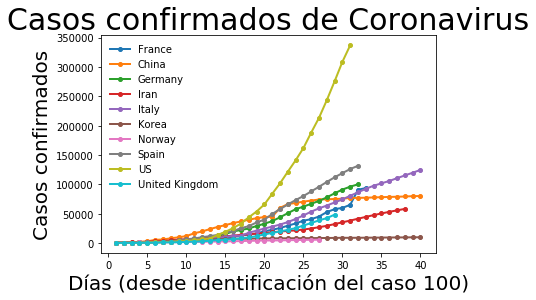

,France,China,Germany,Iran,Italy,"Korea, South",Norway,Spain,US,United Kingdom
36,NaN,78600.0,NaN,53183.0,105792.0,9478.0,NaN,NaN,NaN,NaN
37,NaN,78928.0,NaN,55743.0,110574.0,9583.0,NaN,NaN,NaN,NaN
38,NaN,79356.0,NaN,58226.0,115242.0,9661.0,NaN,NaN,NaN,NaN
39,NaN,79932.0,NaN,NaN,119827.0,9786.0,NaN,NaN,NaN,NaN
40,NaN,80136.0,NaN,NaN,124632.0,9887.0,NaN,NaN,NaN,NaN


In [12]:
'''Vamos a hacer un gráfico para ver los casos confirmados (desde caso 100)'''

# Coger solo datos del último mes
data_time_30days = data_time[-200:]
# Si quiero quitar China: data_time_filter = data_time_filter.drop('China', axis=1)

#Exporto los datos en diferentes arhcivos con casa país
for country in list_countries:
    dataX = data_time_30days[country]
    dataX = dataX[dataX > 200]
    dataX.to_csv('data_' + country + ".csv", index=False, header= country)

#Lista dataframes
dataframes_list = ['dataframe_France', 'dataframe_China', 'dataframe_Germany', 'dataframe_Iran', 'dataframe_Italy', 'dataframe_Korea', 'dataframe_Norway', 'dataframe_Spain', 'dataframe_US', 'dataframe_UnitedKingdom']
dataframes_list[1]

# Creamos los CSV
dataframe_France = pd.read_csv('data_France.csv')
dataframe_China = pd.read_csv('data_China.csv')
dataframe_Germany = pd.read_csv('data_Germany.csv')
dataframe_Iran = pd.read_csv('data_Iran.csv')
dataframe_Italy = pd.read_csv('data_Italy.csv')
dataframe_Korea = pd.read_csv('data_Korea, South.csv')
dataframe_Norway = pd.read_csv('data_Norway.csv')
dataframe_Spain = pd.read_csv('data_Spain.csv')
dataframe_US = pd.read_csv('data_US.csv')
dataframe_UnitedKingdom = pd.read_csv('data_United Kingdom.csv')

#Les añadimos NaN al final y reindexamos
new_index = np.arange(1,41)
dataframe_France = dataframe_France.reindex(new_index)
dataframe_China = dataframe_China.reindex(new_index)
dataframe_Germany = dataframe_Germany.reindex(new_index)
dataframe_Iran = dataframe_Iran.reindex(new_index)
dataframe_Italy = dataframe_Italy.reindex(new_index)
dataframe_Korea = dataframe_Korea.reindex(new_index)
dataframe_Norway = dataframe_Norway.reindex(new_index)
dataframe_Spain = dataframe_Spain.reindex(new_index)
dataframe_US = dataframe_US.reindex(new_index)
dataframe_UnitedKingdom = dataframe_UnitedKingdom.reindex(new_index)

# Lo ploteo
plt.plot(dataframe_France, label='France', marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_China, label='China',marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Germany, label='Germany' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Iran, label='Iran',marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Italy, label='Italy',marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Korea, label='Korea' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Norway, label='Norway' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_Spain, label='Spain' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_US, label='US' ,marker='o', markersize=4, linewidth=2)
plt.plot(dataframe_UnitedKingdom, label='United Kingdom',marker='o', markersize=4, linewidth=2)

plt.legend(loc='upper left', frameon=False, fancybox=True)
plt.title('Casos confirmados de Coronavirus', {'fontsize': 30})

plt.xlabel("Días (desde identificación del caso 100)", {'fontsize': 20})
plt.ylabel("Casos confirmados", {'fontsize': 20})
plt.show()

#Juntar dataframes y Exportar CSV completo
data_drive_from100cases = dataframe_France.join([dataframe_China, dataframe_Germany, dataframe_Iran, dataframe_Italy, dataframe_Korea, dataframe_Norway, dataframe_Spain, dataframe_US,dataframe_UnitedKingdom])

# Declare a list that is to be converted into a column

'''doubleday = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600, 51200, 102400, 204800, 409600, 819200, 
         'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 
         'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 
         'NaN', 'NaN', 'NaN']

# doubletwodays = [100, (100*2)-(100/2), 200, (200*2)-(200/2), 800, (800*2)-(800/2), 1600,(1600*2)-(1600/2), 3200,
                 (3200*2)-(3200/2), 6400, (6400*2)-(6400/2), 12800, (12800*2)-(12800/2), 25600, (25600*2)-(25600/2),
                 51200, (51200*2)-(51200/2), 102400, (102400*2)-(102400/2), 204800, (204800*2)-(204800/2), 409600, (409600*2)-(409600/2), 
        819200, (819200*2)-(819200/2), 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN']
'''

# Using 'Address' as the column name 
# and equating it to the list 
# data_drive_from100cases['Doble cada día'] = doubleday
# data_drive_from100cases['Doble cada dos días'] = doubletwodays

data_drive_from100cases.to_csv('covid19_data_drive_from100.csv', sep = ';')
data_drive_from100cases.tail()

## MUNDO: CSV covid19_data_drive_days.csv

/Users/victormac/anaconda3/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


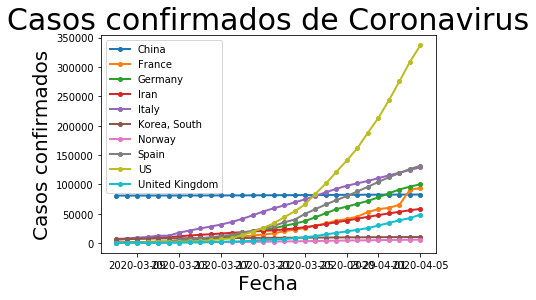

Country/Region,China,France,Germany,Iran,Italy,"Korea, South",Norway,Spain,US,United Kingdom
2020-04-01,82361.0,57749.0,77872.0,47593.0,110574.0,9887.0,4863.0,104118.0,213372.0,29865.0
2020-04-02,82432.0,59929.0,84794.0,50468.0,115242.0,9976.0,5147.0,112065.0,243453.0,34173.0
2020-04-03,82511.0,65202.0,91159.0,53183.0,119827.0,10062.0,5370.0,119199.0,275586.0,38689.0
2020-04-04,82543.0,90848.0,96092.0,55743.0,124632.0,10156.0,5550.0,126168.0,308850.0,42477.0
2020-04-05,82602.0,93773.0,100123.0,58226.0,128948.0,10237.0,5687.0,131646.0,337072.0,48436.0


In [13]:
# Coger solo datos de últimos 60 días
data_time_Xdays = data_time[-30:]
# Si quiero quitar China: data_time_filter = data_time_filter.drop('China', axis=1)
data_time_Xdays.tail(2)

'''Vamos a hacer un gráfico para ver los casos confirmados por fechas'''
plt.plot(data_time_Xdays, label='France', marker='o', markersize=4, linewidth=2)
plt.title('Casos confirmados de Coronavirus', {'fontsize': 30})
plt.xlabel("Fecha", {'fontsize': 20})
plt.ylabel("Casos confirmados", {'fontsize': 20})
plt.legend(list_countries)

plt.show()

#Exportar CSV por días progresivos
data_drive_lastX = data_time_Xdays.loc[:,list_countries]
data_drive_lastX.to_csv('covid19_data_drive_days.csv', sep = ';', encoding="utf-8")
data_drive_lastX.tail()


# Gráficos a nivel España

## ESPAÑA: CSV: covid19_spain_ccaa.csv datos principales

In [14]:
#Exportar CSV
data_spain_ccaa.to_csv('covid19_spain_ccaa.csv', sep = ';', encoding="utf-8")
data_spain_ccaa.head(19)

,Confirmados,Curados,Fallecidos,Nuevos casos (24h)
Comunidades Autónomas,,,,
Andalucía,8581,798,491,280
Aragón,3347,565,284,115
Asturias,1646,222,86,41
Baleares,1320,531,81,27
Canarias,1649,157,85,27
Cantabria,1483,118,77,42
Castilla La Mancha,10602,1259,1132,571
Castilla y León,9116,2533,919,367
Cataluña,26824,10088,2760,792


## ESPAÑA: CSV: covid19_spain_ccaa_lineal.csv

In [16]:
data_process = pd.read_csv("covid19_spain_ccaa_evolution2.csv", sep = ';', encoding="utf-8") #cambiar el data evolution
print('Si sale FALSE, no es igual y tiene que actualizarse >>>>>>>>' , data_process.columns[-1] == data_spain_ccaa_last.name)

NameError: name 'data_spain_ccaa_last' is not defined

In [18]:
# Sacar fecha en formato correcto
fecha_data_spain = get_fecha(raw['content'])
fecha_data_spain = pd.Timestamp(year=int(fecha_data_spain[6:10]), month=int(fecha_data_spain[3:5]), day=int(fecha_data_spain[1:2]), hour=12)
fecha_data_spain = fecha_data_spain.strftime('%Y-%m-%d')
print(fecha_data_spain)

# Cojo la fila de confirmados que me interesa
data_spain_ccaa_last = data_spain_ccaa.copy()
data_spain_ccaa_last.rename(columns = {'Confirmados': fecha_data_spain}, index={'ccaa': 'Comunidades Autónomas'}, inplace = True)
data_spain_ccaa_last = data_spain_ccaa_last[fecha_data_spain]
data_spain_ccaa_last = pd.to_numeric(data_spain_ccaa_last).astype(np.int64)
data_spain_ccaa_last.head()

#HACER MERGE SI NO ESTÁN ESOS DATOS

# Importo los últimos datos recogidos acumulados anteriormente
data_process = pd.read_csv("covid19_spain_ccaa_evolution2.csv", sep = ';', encoding="utf-8")
data_process = data_process.set_index('Comunidades Autónomas')

# Hacer merge de ambos dataframes, con un condicional comprobando si es necesario
if data_process.columns[-1] == data_spain_ccaa_last.name:
    print('La columna ya está: NO hacer merge y no se exporta tabla')
else:
    print('La última columna es diferente y no está: SE HACE MERGE')
    data_process = pd.merge(data_process,data_spain_ccaa_last, left_index=True, right_index=True)
    #Exportar a CSV
    data_process.to_csv('covid19_spain_ccaa_evolution2.csv', sep = ';', encoding="utf-8", index=True, index_label='Comunidades Autónomas')

data_process.head(1)

(COVID-19).  

06.04
2020-04-06
La columna ya está: NO hacer merge y no se exporta tabla


,2020-03-01,2020-03-02,2020-03-03,2020-03-04,2020-03-05,2020-03-06,2020-03-07,2020-03-08,2020-03-09,2020-03-10,...,2020-03-28,2020-03-29,2020-03-30,2020-03-31,2020-04-01,2020-04-02,2020-04-03,2020-04-04,2020-04-05,2020-04-06
Comunidades Autónomas,,,,,,,,,,,,,,,,,,,,,
Andalucía,6,12,13,13,13,21,21,21,54,71,...,4277,4682,5405,5818,6392,6972,7374,7869,8301,8581


## ESPAÑA: Análisis por edades : CSV : covid19_spain_ccaa_ages.csv

In [19]:
#Traigo la segunda tabla
data_spain_ccaa_age = tabula.read_pdf(path_spain, stream=True, pages=2)[0]
data_spain_ccaa_age = data_spain_ccaa_age.iloc [:, [0,1,3,7]]
data_spain_ccaa_age.columns = ['Grupos de edad','Confirmados', 'Hospitalizados', 'Fallecidos']
data_spain_ccaa_age['Confirmados'] = data_spain_ccaa_age['Confirmados'].str.replace('.','')
data_spain_ccaa_age['Fallecidos'] = data_spain_ccaa_age['Fallecidos'].str.replace('.','')
data_spain_ccaa_age['Hospitalizados'] = data_spain_ccaa_age['Hospitalizados'].str.replace('.','')
data_spain_ccaa_age.set_index('Grupos de edad', inplace=True)

# Saco por edades general
data_spain_ccaa_age_general = data_spain_ccaa_age.iloc [4:15, :]
data_spain_ccaa_age_general.to_csv('covid19_spain_ccaa_ages.csv', sep = ';', encoding="utf-8")

#Saco por mujeres
data_spain_ccaa_age_mujeres = data_spain_ccaa_age.iloc [22:31, :]
data_spain_ccaa_age_mujeres.to_csv('covid19_spain_ccaa_ages_mujeres.csv', sep = ';', encoding="utf-8")

#Saco por hombres
data_spain_ccaa_age_hombres = data_spain_ccaa_age.iloc [39:49, :]
data_spain_ccaa_age_hombres.to_csv('covid19_spain_ccaa_ages_hombres.csv', sep = ';', encoding="utf-8")


# Subir archivos a SERVIDOR desde FTP

In [20]:
import csv
from ftplib import FTP
from io import StringIO

In [22]:
# Ayuda: https://www.pythoncircle.com/post/668/uploading-a-file-to-ftp-server-using-python/

passw = pd.read_csv("pass.txt", sep = ',', encoding="utf-8")
host = "akakicreations.com"
username = passw.columns[0]
password = passw.columns[1]

ftp = FTP(host=host)

login_status = ftp.login(user=username, passwd=password)
print(login_status)

print(ftp.dir())
fp = open("covid19_data_drive_days.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_data_drive_days.csv"), fp, 1024)
fp = open("covid19_data_drive_from100.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_data_drive_from100.csv"), fp, 1024)
fp = open("covid19_spain_ccaa.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_spain_ccaa.csv"), fp, 1024)
fp = open("covid19_spain_ccaa_evolution2.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_spain_ccaa_evolution2.csv"), fp, 1024)
fp = open("covid19_data_drive_actual.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_data_drive_actual.csv"), fp, 1024)
fp = open("covid19_data_drive_resume.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_data_drive_resume.csv"), fp, 1024)
fp = open("covid19_spain_ccaa_ages.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_spain_ccaa_ages.csv"), fp, 1024)
fp = open("covid19_spain_ccaa_ages_mujeres.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_spain_ccaa_ages_mujeres.csv"), fp, 1024)
fp = open("covid19_spain_ccaa_ages_hombres.csv", 'rb')
ftp.storbinary('STOR %s' % os.path.basename("covid19_spain_ccaa_ages_hombres.csv"), fp, 1024)
fp.close()

230-OK. Current restricted directory is /
230 312 Kbytes used (0%) - authorized: 51200 Kb
drwxr-xr-x    2 akakicre   akakicre         4096 Apr  6 08:43 .
drwxr-xr-x    2 akakicre   akakicre         4096 Apr  6 08:43 ..
-rw-------    1 akakicre   akakicre           10 Apr  6 10:59 .ftpquota
-rw-r--r--    1 akakicre   akakicre       260069 Apr  3 12:34 Imagen_github.jpg
-rw-r--r--    1 akakicre   akakicre          262 Apr  6 10:59 covid19_data_drive_actual.csv
-rw-r--r--    1 akakicre   akakicre         2679 Apr  6 10:59 covid19_data_drive_days.csv
-rw-r--r--    1 akakicre   akakicre         2791 Apr  6 10:59 covid19_data_drive_from100.csv
-rw-r--r--    1 akakicre   akakicre          123 Apr  6 10:59 covid19_data_drive_resume.csv
-rw-r--r--    1 akakicre   akakicre          577 Apr  6 10:59 covid19_spain_ccaa.csv
-rw-r--r--    1 akakicre   akakicre          257 Apr  6 10:59 covid19_spain_ccaa_ages.csv
-rw-r--r--    1 akakicre   akakicre          224 Apr  6 10:59 covid19_spain_ccaa_ages_h